Metrics data written to: metrics_data.csv


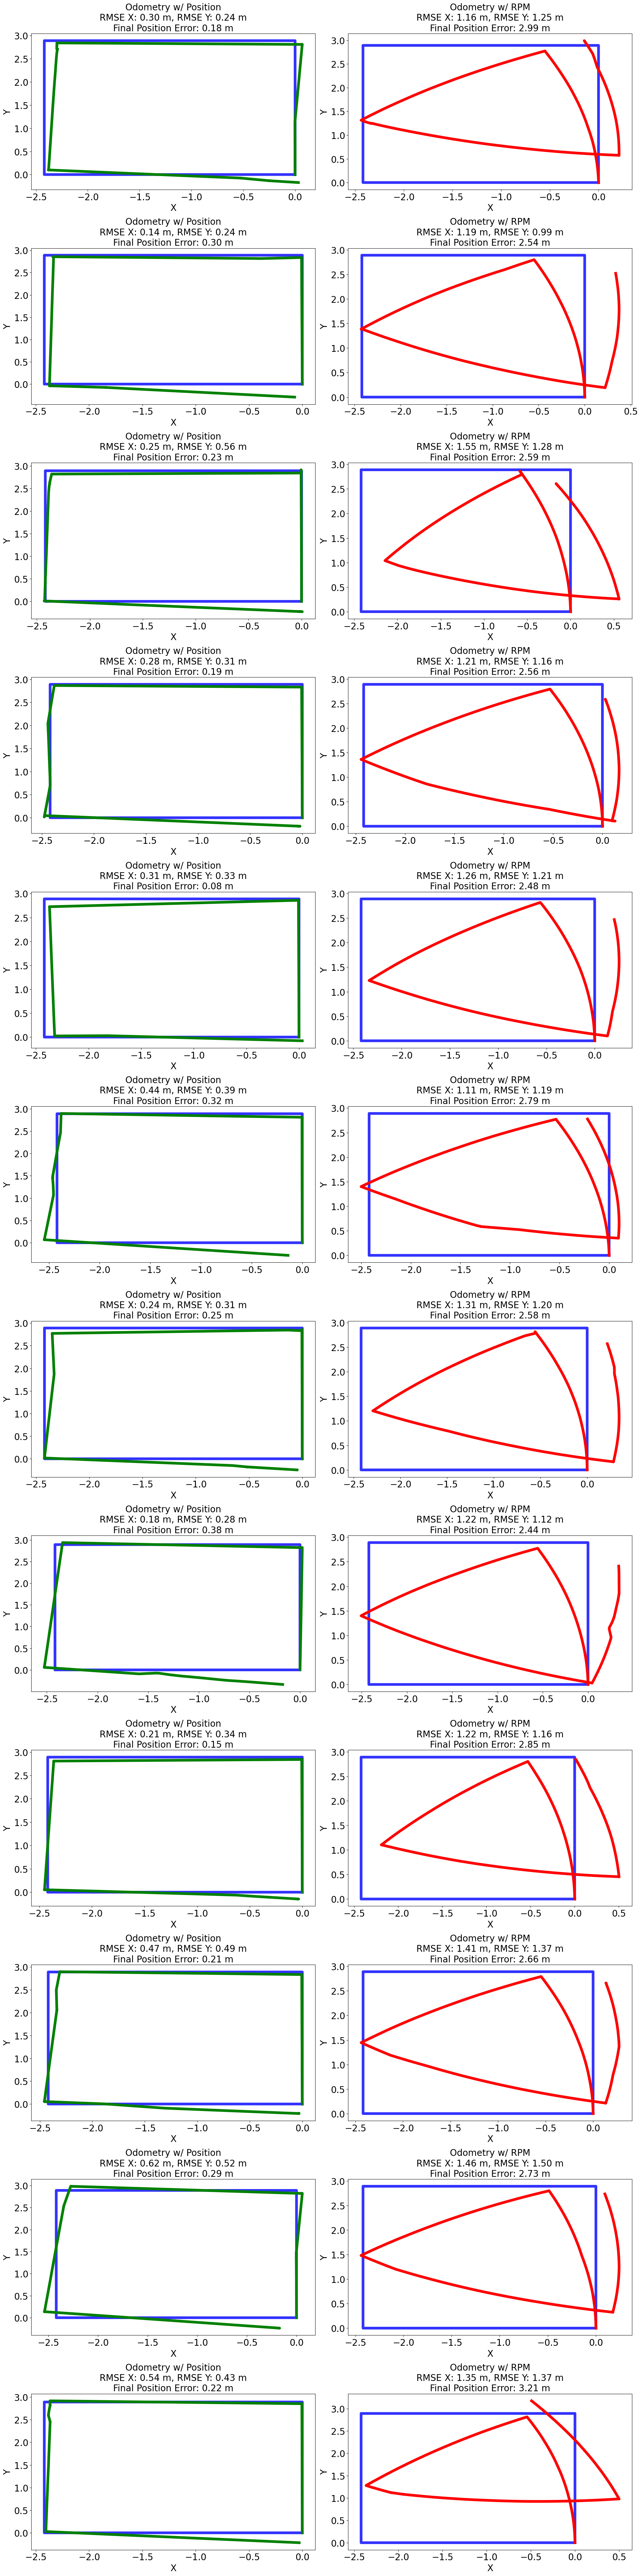

In [ ]:
import csv
import matplotlib.pyplot as plt
import os
import ast
import re
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.interpolate import interp1d
import math

# Define directory path and initialize variables
directory_path = "/home/ziczac/dev/skripsi_code/ROS2-PLICP-POSE-GRAPH/data_store/20rpm/"
files = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]
metrics_data = []

# Generate the reference odometry data
def generate_odometry_data():
    x, y = 0, 0
    x_path, y_path = [x], [y]

    for _ in range(289):
        y += 1 / 100
        x_path.append(x)
        y_path.append(y)
    for _ in range(242):
        x -= 1 / 100
        x_path.append(x)
        y_path.append(y)
    for _ in range(289):
        y -= 1 / 100
        x_path.append(x)
        y_path.append(y)
    for _ in range(242):
        x += 1 / 100
        x_path.append(x)
        y_path.append(y)

    return np.array(x_path), np.array(y_path)

x_path_reference, y_path_reference = generate_odometry_data()

# Set up the plot
fig, axs = plt.subplots(12, 2, figsize=(20, 80))

# Process each file
for i, file in enumerate(files):
    file_path = os.path.join(directory_path, file)

    rpm_left, rpm_right, pos_left, pos_right, pose_all, timestamps = [], [], [], [], [], []

    with open(file_path, 'r') as f:
        csv_reader = csv.DictReader(f)
        for row in csv_reader:
            if row['RPM_Left'].strip():
                rpm_left.append(float(row['RPM_Left']))
            if row['RPM_Right'].strip():
                rpm_right.append(float(row['RPM_Right']))
            if row['Pos_Left'].strip():
                pos_left.append(float(row['Pos_Left']))
            if row['Pos_Right'].strip():
                pos_right.append(float(row['Pos_Right']))
            pose_all.append(row['Pose'])
            match = re.search(r'nanoseconds=(\d+)', row['time_stamp'])
            if match:
                timestamps.append(int(match.group(1)))

    pose_all = pose_all[len(pose_all) - len(rpm_left) - 2:-1]
    pose_list = [ast.literal_eval(pose) for pose in pose_all]

    if file in ["15-05|10:57:07.csv", "15-05|10:39:31.csv", "15-05|10:43:27.csv", "15-05|10:57:07.csv", "15-05|10:52:10.csv", "15-05|10:48:00.csv"]:
        x = [-pose[0] for pose in pose_list]
        y = [pose[1] for pose in pose_list]
    else:
        x = [pose[0] for pose in pose_list]
        y = [pose[1] for pose in pose_list]
    theta_pose = [pose[2] for pose in pose_list]

    x_rotated = [-val for val in y]
    y_rotated = [val for val in x]

    min_length = min(len(x_rotated), len(x_path_reference))

    interp_func_x = interp1d(np.linspace(0, 1, len(x_rotated)), x_rotated)
    interp_func_y = interp1d(np.linspace(0, 1, len(y_rotated)), y_rotated)

    x_rotated_interp = interp_func_x(np.linspace(0, 1, min_length))
    y_rotated_interp = interp_func_y(np.linspace(0, 1, min_length))

    x_path_reference_interp = x_path_reference[:min_length]
    y_path_reference_interp = y_path_reference[:min_length]

    mse_x = mean_squared_error(x_path_reference_interp, x_rotated_interp)
    mse_y = mean_squared_error(y_path_reference_interp, y_rotated_interp)
    rmse_x = np.sqrt(mse_x)
    rmse_y = np.sqrt(mse_y)
    final_position_error = np.sqrt((x_path_reference_interp[-1] - x_rotated_interp[-1])**2 + (y_path_reference_interp[-1] - y_rotated_interp[-1])**2)

    x_odom, y_odom, theta_odom = 0, 0, 0
    x_store, y_store = [x_odom], [y_odom]
    wheel_radius = 0.0504
    wheel_base = 0.283
    prev_time = timestamps[0]

    for j in range(1, len(rpm_left)):
        delta_t = (timestamps[j] - prev_time) * 1e-9
        prev_time = timestamps[j]

        d_left_rpm = (-rpm_left[j] * 2 * math.pi * wheel_radius / 60) * delta_t
        d_right_rpm = (rpm_right[j] * 2 * math.pi * wheel_radius / 60) * delta_t

        d_distance = (d_left_rpm + d_right_rpm) / 2
        d_theta = (d_right_rpm - d_left_rpm) / wheel_base

        odom_dy = d_distance * -math.cos(theta_odom + d_theta / 2)
        odom_dx = d_distance * -math.sin(theta_odom + d_theta / 2)

        x_odom += odom_dx
        y_odom += odom_dy
        theta_odom = (theta_odom + d_theta) % (2 * math.pi)

        x_store.append(x_odom)
        y_store.append(y_odom)

    x_store = [val for val in x_store]
    y_store = [val for val in y_store]

    min_length_rpm = min(len(x_store), len(x_path_reference))

    interp_func_x_rpm = interp1d(np.linspace(0, 1, len(x_store)), x_store)
    interp_func_y_rpm = interp1d(np.linspace(0, 1, len(y_store)), y_store)

    x_store_interp = interp_func_x_rpm(np.linspace(0, 1, min_length_rpm))
    y_store_interp = interp_func_y_rpm(np.linspace(0, 1, min_length_rpm))

    x_path_reference_interp_rpm = x_path_reference[:min_length_rpm]
    y_path_reference_interp_rpm = y_path_reference[:min_length_rpm]

    mse_x_rpm = mean_squared_error(x_path_reference_interp_rpm, x_store_interp)
    mse_y_rpm = mean_squared_error(y_path_reference_interp_rpm, y_store_interp)
    rmse_x_rpm = np.sqrt(mse_x_rpm)
    rmse_y_rpm = np.sqrt(mse_y_rpm)
    final_position_error_rpm = np.sqrt((x_path_reference_interp_rpm[-1] - x_store_interp[-1])**2 + (y_path_reference_interp_rpm[-1] - y_store_interp[-1])**2)

    # Plot the paths
    axs[i, 0].plot(x_path_reference_interp, y_path_reference_interp, color='blue', label='Reference Path', alpha=0.8,linewidth = 6)
    axs[i, 0].plot(x_rotated_interp, y_rotated_interp, color='green', label='Odometry POS', linewidth = 6)

    title = (f'Odometry w/ Position\n'
             f'RMSE X: {rmse_x:.2f} m, RMSE Y: {rmse_y:.2f} m\n'
             f'Final Position Error: {final_position_error:.2f} m')
    axs[i, 0].set_title(title, size=20)
    axs[i, 0].tick_params(axis='x', labelsize=20)
    axs[i, 0].tick_params(axis='y', labelsize=20)
    axs[i, 0].set_xlabel('X', size=20)
    axs[i, 0].set_ylabel('Y', size=20)

    axs[i, 1].plot(x_path_reference_interp_rpm, y_path_reference_interp_rpm, color='blue', label='Reference Path', alpha=0.8, linewidth = 6)
    axs[i, 1].plot(x_store_interp, y_store_interp, color='red', label='Odometry RPM', linewidth = 6)
    title_rpm = (f'Odometry w/ RPM\n'
             f'RMSE X: {rmse_x_rpm:.2f} m, RMSE Y: {rmse_y_rpm:.2f} m\n'
             f'Final Position Error: {final_position_error_rpm:.2f} m')
    axs[i, 1].set_title(title_rpm, size=20)
    axs[i, 1].tick_params(axis='x', labelsize=20)
    axs[i, 1].tick_params(axis='y', labelsize=20)
    axs[i, 1].set_xlabel('X', size=20)
    axs[i, 1].set_ylabel('Y', size=20)
    metrics_data.append({
        'File': file,
        'RMSE_X_POS': rmse_x,
        'RMSE_Y_POS': rmse_y,
        'Final_Position_Error_POS': final_position_error,
        'RMSE_X_RPM': rmse_x_rpm,
        'RMSE_Y_RPM': rmse_y_rpm,
        'Final_Position_Error_RPM': final_position_error_rpm,
    })

# Save metrics data to CSV
csv_file_path = 'metrics_data.csv'
with open(csv_file_path, mode='w', newline='') as csv_file:
    fieldnames = ['File', 'RMSE_X_POS', 'RMSE_Y_POS', 'Final_Position_Error_POS', 'RMSE_X_RPM', 'RMSE_Y_RPM', 'Final_Position_Error_RPM']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()
    for data in metrics_data:
        writer.writerow(data)

print("Metrics data written to:", csv_file_path)
plt.tight_layout()
plt.show()

In [56]:
# rpm_left, rpm_right, pos_left, pos_right, timestamps = [], [], [], [], []

# with open("10.csv", 'r') as f:
#     csv_reader = csv.DictReader(f)
#     for row in csv_reader:
#         if row['RPM_Left'].strip():
#             rpm_left.append(float(row['RPM_Left']))
#         if row['RPM_Right'].strip():
#             rpm_right.append(float(row['RPM_Right']))
#         if row['Pos_Left'].strip():
#             pos_left.append(float(row['Pos_Left']))
#         if row['Pos_Right'].strip():
#             pos_right.append(float(row['Pos_Right']))
#         if row['time_stamp'].strip():
#             timestamps.append(float(row['time_stamp']))

In [86]:
x_path_reference_interp_rpm[0], x_path_reference_interp_rpm[1]

(0.0, 0.0)

15-05|11:05:09.csv


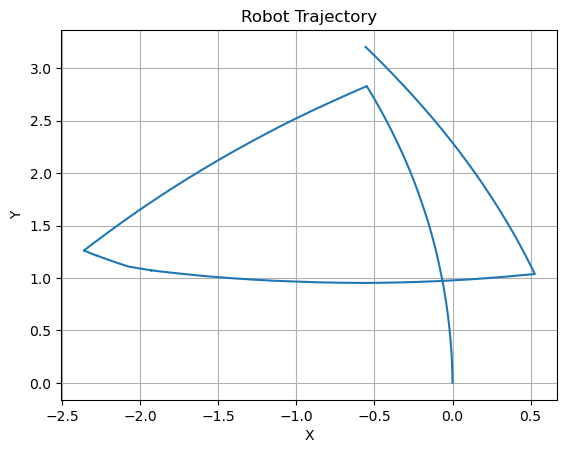

In [81]:
import math
import matplotlib.pyplot as plt

print(file)
# Initialize variables
x = 0
y = 0
theta = 0

x_store = []
y_store = []
theta_store = []

wheel_radius = 0.0503
wheel_base = 0.283

prev_time = timestamps[0]

for i in range(1, len(rpm_left)):
    delta_t = (timestamps[i] - prev_time) * 1e-9

    d_left_rpm = (rpm_left[i] * 2 * math.pi * wheel_radius / 60) * delta_t
    d_right_rpm = (-rpm_right[i] * 2 * math.pi * wheel_radius / 60) * delta_t

    d_distance = (d_left_rpm + d_right_rpm) / 2
    d_theta = (d_right_rpm - d_left_rpm) / wheel_base

    odom_dy = d_distance * math.cos(theta + d_theta / 2)
    odom_dx = d_distance * -math.sin(theta + d_theta / 2)

    x += odom_dx
    y += odom_dy
    theta = (theta + d_theta) % (2 * math.pi)

    x_store.append(x)
    y_store.append(y)
    theta_store.append(theta)
    prev_time = timestamps[i]

plt.plot(x_store, y_store)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Robot Trajectory')
plt.grid(True)
plt.show()

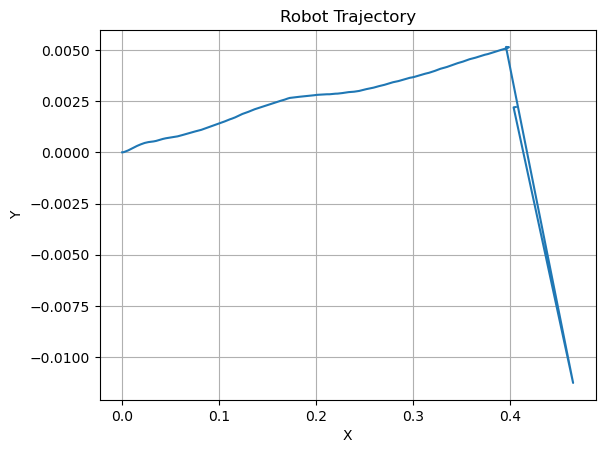

In [66]:
import numpy as np

x = 0
y = 0
theta = 0

x_store = []
y_store = []
theta_store = []
wheel_radius = 0.05

dist_right_pos = 0
dist_left_pos = 0
prev_pos_l = None
prev_pos_r = None

def difference_between_angles(first_angle, second_angle):
    return (second_angle - first_angle + 180) % 360 - 180

def distance_pos(pos_l, pos_r):
    global dist_left_pos, dist_right_pos, prev_pos_r, prev_pos_l
    if prev_pos_l is not None:
        d_theta_L = difference_between_angles(prev_pos_l, pos_l)
        dist_left_pos = (np.pi * 2 * wheel_radius * (d_theta_L / 360))
        prev_pos_l = pos_l
    else:
        prev_pos_l = pos_l
    if prev_pos_r is not None:
        d_theta_R = difference_between_angles(prev_pos_r, pos_r)
        dist_right_pos = (np.pi * 2 * wheel_radius * (d_theta_R / 360))
        prev_pos_r = pos_r
    else:
        prev_pos_r = pos_r

for i in range(len(pos_left)):
    distance_pos(-pos_left[i], pos_right[i])
    d_distance = (dist_left_pos + dist_right_pos) / 2
    d_theta = (dist_right_pos - dist_left_pos) / 0.283

    odom_dx = d_distance * np.cos(theta + d_theta / 2)
    odom_dy = d_distance * np.sin(theta + d_theta / 2)

    x += odom_dx
    y += odom_dy
    theta = (theta + d_theta) % (2 * np.pi)

    x_store.append(x)
    y_store.append(y)
    theta_store.append(theta)

# Plot x and y trajectory
plt.plot(x_store, y_store)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Robot Trajectory')
plt.grid(True)
plt.show()

In [73]:
x_store[-1]*100, y_store[-1]*1000

(40.572641801328636, 2.2107979107591995)

In [70]:
(40.57890510886822 + 40.666171571467935)/2

40.62253834016808